<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
pip install dtw-python

In [139]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import math
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from dtw import *


In [140]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie(serie_,title_,ytitle_,xtitle_,dot_,namefile_):
    fig, ax1 = plt.subplots(figsize=(7,4))
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel(xtitle_, color=LETRASNARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=LETRASNARA, fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)    
    for p in serie_:
        if dot_== True:
           plt.plot(p,alpha=0.4, linestyle='dashed', linewidth=3)
        else:
           plt.plot(p,alpha=0.4)                
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [141]:
## Encuentra los vecinos más cercanos
def get_neighbors(train, test_row, num_neighbors, typedist='euclidean'):
  
    distances = list()

    for train_row in train:
        if typedist == 'dtw':
            dist = dtw(test_row, train_row)
        else:
            dist = euclidean(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])

    neighbors = list()

    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

## Calcula distancia euclidiana
def euclidean(neig1, neig2):
	  distance = 0.0
	  for i in range(len(neig1)):
		    distance += (neig1[i] - neig2[i])**2
	  return sqrt(distance)

In [142]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path        = 'https://drive.google.com/uc?export=download&id=' 
URL_Demanda = 'https://drive.google.com/file/d/1xcpXDTE7H6EBMLOkic5lq-lzSwiLG2ZS/view?usp=sharing'
df_Demanda  = pd.read_csv(path + URL_Demanda .split('/')[-2], usecols=[0] ) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,], 1,2,3,4,5,6,7,8,9,10,11,12,13,15,
df_Demanda.dropna(inplace=True)
serie = df_Demanda.to_numpy()
serie = StandardScaler().fit_transform(serie)
serie =serie.ravel()

In [143]:
def analogo_knn(serie,v,k=10,tol=0.8, typedist='euclidian', typereg='OLS'):    
#    v       : tamanio de la ventana
#    k       : número de vecinos a buscar k
#    tol     : tolerancia de tamaño de ventanas para seleccion de vecinos
#    typedist: medida de distancia, 'dtw' o 'euclidian' o 'pearson'
    t_o = time.time() 
    vecindario    = []         ## vecindario completo
    vecindario_b  = [] 
    distances     = []
    n             = len(serie) ## longitud total de la serie

    ## PASO 1: Selección de las ventanas de mayor correlación.
    Y = serie[n-v:n]

    ## Se calcula la distancia entre todos los vecinos.
    for i in range(n-2*v+1):
        if  typedist == 'dtw': ## Dynamic time warping
            dist = dtw(Y, serie[i:i+v]).distance  
        elif typedist == 'pearson':
            dist = np.corrcoef(Y,serie[i:i+v])[1,0]
        else:
            dist = euclidean(Y,serie[i:i+v])
        if dist > 0:
            distances.append((i, dist))
        #print(Y,serie[i:i+v],i, dist)

    ## Se ordena el vecindario por distancia de menor a mayor y se guardan las posiciones.
    distances.sort(key=lambda tup: tup[1])
    
    print(type(distances),distances)

    neighbors  = []
    neighbors2 = []
    position   = []

    ## Se escogen los k vecinos mas cercanos y guardamos las posiciones.
    i = 0
    for pos, dis in distances:
        #print(serie[pos:pos+v],dis,pos)

        if i==0:      
            position.append(pos)   
            neighbors.append(serie[pos:pos+v])
            neighbors2.append(serie[pos+v:pos+2*v])
        else:
            bandera = True
            for p in position:
                 ## Si ya teniamos una posición en la lista que pase la tolerancia, ya no guardamos 
                if (abs(pos - p) < tol*v):
                    bandera = False
                    i = i - 1
                    break
            if bandera == True:
                ## Guarda nuevo vecino
                position.append(pos)   
                neighbors.append(serie[pos:pos+v])
                neighbors2.append(serie[pos+v:pos+2*v])
                bandera = False
        i = i + 1
        if i == k:
            break
    print('position KNN:',position)    ## posición de los k vecinos mas cercanos

    ## Convertimos a numpy
    neighbors  = np.array(neighbors)
    neighbors2 = np.array(neighbors2)

    print_serie(neighbors, 'KNN - X         ','','time', False,'fig_1')
    print_serie(neighbors2,'KNN - X2 (prima)','','time', False,'fig_2')

    t_sel = time.time() - t_o

    ## PASO 2: Regresión entre los vecinos mas cercanos 'X' y la última ventana 'Y'

    ## Definimos nuestros regresores 
    X   = (neighbors.T).tolist()
    X_2 = (neighbors2.T).tolist()
    Y   = (Y).tolist()

    model   = sm.OLS(Y, X)
    results = model.fit()
    result_prediction = results.predict(X_2)
    #print(results.summary())

    ## Se ordenan los valores 'pi' y se selecciona el más grande.
    i = 0
    pvalues = []
    for pi in results.pvalues:
        pvalues.append((i,pi))
        i = i + 1
    pvalues.sort(key=lambda tup: tup[1]) 
    print(pvalues)
    (i, pi) = pvalues[0] #len(pvalues)-1 ## ordena por pi HAY UN ERROR AQUI!!!!!!! SE ESTÁ ESCOGIENDO EL PI MAS CHICO , NO EL MAS GRANDE !!!!!!!!!
    print('pi_0:',pi)

    ## Proceso de regresión OLS con stepwise
    while pi > 0.01:
        X   = sm.add_constant(X)
        X_2 = sm.add_constant(X_2) 
        print('Retiramos regresor X' + str(i))
        X   = np.delete(arr=X,   obj=i+0, axis=1)
        X_2 = np.delete(arr=X_2, obj=i+0, axis=1)   
        model   = sm.OLS(Y, X)
        results = model.fit()

        ## Se ordenan los valores 'pi' y se selecciona el más grande
        i = 0
        pvalues = []
        for pi in results.pvalues:
            pvalues.append((i,pi))
            i = i + 1
        pvalues.sort(key=lambda tup: tup[1])
        (i, pi) = pvalues[0] #len(pvalues)-1 ## ordena por 'pi' HAY UN ERROR AQUI!!!!!!! SE ESTÁ ESCOGIENDO EL PI MAS CHICO , NO EL MAS GRANDE !!!!!!!!!
        print('pi',i,':',pi)
    #print(results.summary())    

    #prediction    = results.predict(X)
    prediction_Y2 = results.predict(X_2)
    t_reg = time.time() - t_sel  

    return prediction_Y2, t_sel, t_reg

## Probamos el modelo con 'pearson' y 'OLS'.

<class 'list'> [(24994, 5.443741426146403e-05), (8397, 0.00022078532765295493), (15774, 0.00032523267655469216), (21282, 0.0003559753160845651), (5694, 0.00036989079044714345), (14341, 0.000494577199604428), (14929, 0.0005442044372719482), (10908, 0.0005723977801123516), (10296, 0.0005725364837890594), (4544, 0.0005875425737162092), (12149, 0.0007441894699513006), (4846, 0.0007869478100325674), (8278, 0.0008103852899752694), (20227, 0.0009077941550799282), (22239, 0.000954844296509028), (16944, 0.0009739197130617873), (9730, 0.0011574559755535975), (18665, 0.0011785539942781205), (21440, 0.0012603005006288145), (12422, 0.0012885950805761892), (14629, 0.0013232455792498475), (23961, 0.0014334652393171194), (2357, 0.001470386960061977), (6854, 0.0016639630497742271), (19073, 0.0017147738770210653), (18963, 0.0017223836628438036), (7336, 0.0017456606752208027), (511, 0.0018561338532366376), (18086, 0.0018624694817969073), (1779, 0.0019497587308910996), (15040, 0.002005064221807822), (6096

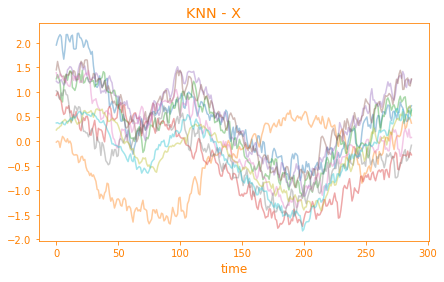

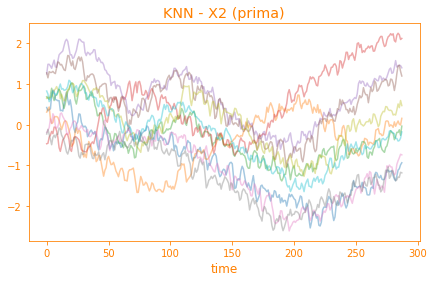

[(9, 0.003256997271514439), (5, 0.03942956066747045), (4, 0.06848800500610928), (3, 0.23078803797930497), (7, 0.34618208672035466), (1, 0.3822488626741801), (0, 0.5977192894511443), (6, 0.8093206077734095), (8, 0.8746954193177586), (2, 0.9225158782601285)]
pi_0: 0.003256997271514439
tiempo de selección: 3.489382028579712
tiempo de regresión 1651929872.3458421
Test MAE, pea, OLS =  0.5873186674195443


In [144]:
## PROBAMOS EL MODELO con la última ventana
if 1==1:
    x_train = serie[0 : len(serie) - 288]
    y_test  = serie[len(serie) - 288 : ]
    pred_pea_ols, t_sel, t_reg = analogo_knn(x_train,v=288,k=10,tol=0.8,typedist='pearson',typereg='OLS')
    print('tiempo de selección:',t_sel)
    print('tiempo de regresión', t_reg)

    # Exactitud del modelo
    err_pea_ols = mean_absolute_error(y_test,pred_pea_ols)
    print('Test MAE, pea, OLS = ', err_pea_ols)

## Probamos el modelo con 'euclidian' y 'OLS' 

<class 'list'> [(22179, 4.905420307441227), (20740, 4.994289935293412), (22178, 4.994759126438676), (20739, 4.995690428378187), (22180, 5.013163243532423), (20738, 5.017265192721156), (20741, 5.027915126351497), (20737, 5.123863139413452), (20742, 5.124981706438358), (22467, 5.157324592509036), (22468, 5.158396507907972), (22177, 5.18890200312127), (22181, 5.24091750583485), (22466, 5.26092325796539), (20743, 5.29297855690636), (21892, 5.301995637055784), (21891, 5.3110901416738185), (21890, 5.320129899320716), (22469, 5.340765864778269), (20736, 5.35831703303847), (22176, 5.375766379962222), (21889, 5.377072543258294), (21893, 5.389728766081449), (22465, 5.424820480222296), (20744, 5.425148447154713), (22182, 5.4857215578352205), (21894, 5.52268299025208), (22464, 5.5636526617787005), (21888, 5.565215811647809), (22175, 5.589261467411183), (22470, 5.592088898345738), (20745, 5.598206220799679), (22754, 5.6061353618461744), (22755, 5.608523285533271), (20735, 5.620722503538098), (22463

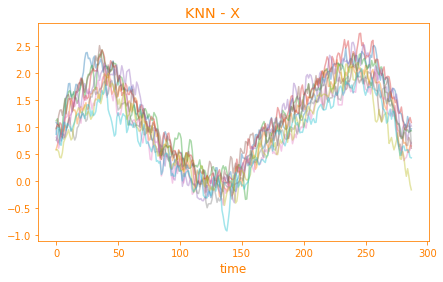

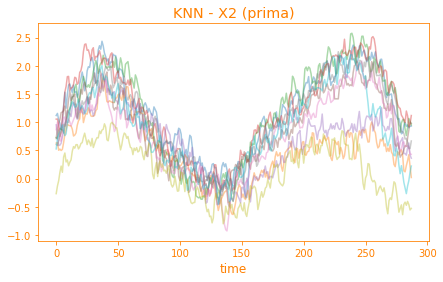

[(6, 9.792503403129622e-09), (8, 1.1160514321448238e-06), (2, 0.03865786332485549), (9, 0.058711261349041415), (0, 0.09556614566429328), (7, 0.31699029615405716), (4, 0.36134265701325174), (3, 0.8308147358876831), (1, 0.9622066028142418), (5, 0.9785941951991044)]
pi_0: 9.792503403129622e-09
tiempo de selección: 5.073540687561035
tiempo de regresión: 1651929875.8674448
Test MAE, euclidian, OLS =  0.3888115238451104


In [145]:
## PROBAMOS EL MODELO con la última ventana
if 1==1:
    x_train = serie[0 : len(serie) - 288]
    y_test  = serie[len(serie) - 288 : ]
    pred_euc_ols, t_sel, t_reg = analogo_knn(x_train,v=288,k=10,tol=0.8,typedist='euclidian',typereg='OLS')
    print('tiempo de selección:',t_sel)
    print('tiempo de regresión:',t_reg)

    # Exactitud del modelo
    err_euc_ols = mean_absolute_error(y_test,pred_euc_ols)
    print('Test MAE, euclidian, OLS = ',err_euc_ols)

## Probamos el modelo con 'dtw' y 'OLS'.

<class 'list'> [(22757, 36.45892859615522), (22758, 36.48108600421109), (20745, 36.586431616298206), (20746, 36.78413966177651), (22759, 36.78536064508415), (20743, 36.81761589113496), (20744, 36.88478384714067), (22760, 37.35199338699633), (20747, 37.384632704827894), (22184, 37.50561121146053), (24781, 37.64527446844228), (24779, 37.704944335316995), (24774, 37.74703176681803), (24780, 37.751695371449614), (24778, 37.8211894816567), (24777, 37.84661729278661), (22761, 37.93201331867731), (24775, 37.93936686242267), (24782, 37.9489214444972), (24773, 38.01733546143857), (21896, 38.036221359969055), (20748, 38.14961361185292), (20738, 38.16865330853933), (20737, 38.201427723474936), (24776, 38.262055225253604), (24772, 38.273365936443184), (22178, 38.28604465570343), (20742, 38.31695015302375), (20741, 38.318891366503706), (22751, 38.44812692402226), (20740, 38.44819669126947), (22185, 38.46676242860647), (20739, 38.5113066942978), (24771, 38.631198025798255), (22175, 38.69330916703204

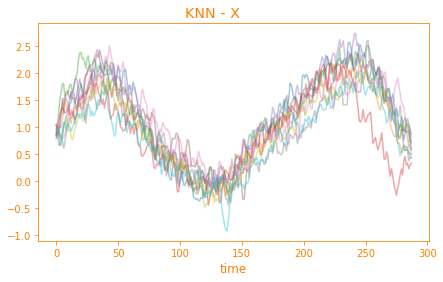

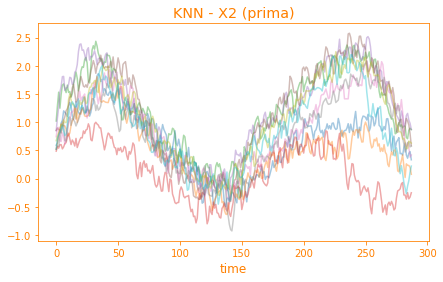

[(7, 1.6815055922100668e-06), (9, 1.3895285874585766e-05), (5, 0.00022595668430034282), (3, 0.0005705089324219092), (1, 0.0029716920850489715), (6, 0.08498254040308688), (0, 0.24928164120592172), (4, 0.26059041512045844), (8, 0.6167014266007002), (2, 0.9894947333580479)]
pi_0: 1.6815055922100668e-06
tiempo de selección: 189.96391463279724
tiempo de regresión 1651929880.973506
Test MAE, dtw, OLS =  0.49824083527208707


In [146]:
## PROBAMOS EL MODELO con la última ventana
if 1==1:
    x_train = serie[0 : len(serie) - 288]
    y_test  = serie[len(serie) - 288 : ]
    pred_dtw_ols, t_sel, t_reg = analogo_knn(x_train,v=288,k=10,tol=0.8,typedist='dtw',typereg='OLS')
    print('tiempo de selección:',t_sel)
    print('tiempo de regresión', t_reg)

    # Exactitud del modelo
    err_dtw_ols = mean_absolute_error(y_test,pred_dtw_ols)
    print('Test MAE, dtw, OLS = ', err_dtw_ols)

## Comparamos graficamente los resultados

In [147]:
print('err_pea_ols',err_pea_ols)
print('err_euc_ols',err_euc_ols)
print('err_dtw_ols',err_dtw_ols)

err_pea_ols 0.5873186674195443
err_euc_ols 0.3888115238451104
err_dtw_ols 0.49824083527208707


No handles with labels found to put in legend.


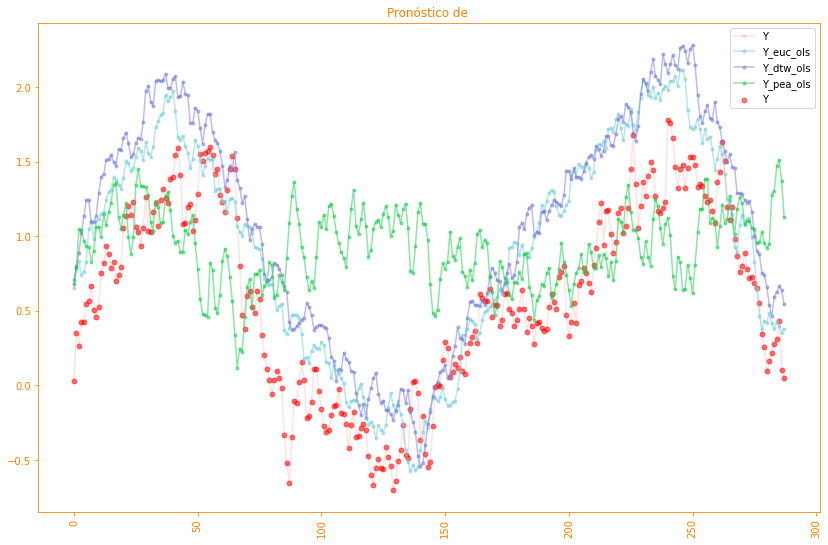

In [148]:
fig  = plt.figure(figsize=(14,9))
axes = fig.add_subplot(1, 1, 1)
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
mytitle = plt.title('Pronóstico de ') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA) #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(colors=LETRASNARA, which='both')

AUX = np.arange( len(y_test) )
plt.scatter ( AUX, y_test, s=25,marker='o', color = 'red', label = 'Y', alpha=1/2)
axes.plot   ( y_test ,      '.-', color = 'red' , label = 'Y',         alpha=1/9)
axes.plot   ( pred_euc_ols, '.-', color = CYAN  , label = 'Y_euc_ols', alpha=1/2)
axes.plot   ( pred_dtw_ols, '.-', color = LILA  , label = 'Y_dtw_ols', alpha=1/2)
axes.plot   ( pred_pea_ols, '.-', color = VERDE , label = 'Y_pea_ols', alpha=1/2)
#axes.plot  ( y_pred_poly, '.-', color = VERDE , label = 'SVM poly'   ,alpha=1/2)
#axes.plot  ( y_pred_linear, '.-', color = AZUL , label = 'SVM linear'   ,alpha=1/2)
#axes.plot  ( y_local_list[1], '.-' , color = VERDE      , label = 'Y_local,k=25'   ,alpha=1/2)
#axes.plot  ( y_local_list[2], '.-' , color = AZUL       , label = 'Y_local,k=35'   ,alpha=1/2)
#axes.plot  ( y_local_list[3], '.-' , color = LILA       , label = 'Y_local,k=50'   ,alpha=1/2)
#axes.plot  ( y_local_list[4], '.-' , color = CYAN       , label = 'Y_local,k=100'  ,alpha=1/2)
#axes.plot  ( y_lineal         , '--' , color = 'red'      , label = 'lineal'       ,alpha=1/2)
#axes.plot  ( y      , '.-'  , color = 'red'        , label = 'Y'  ,alpha=1/2)
#axes.plot  ( y_local, '.-'  , color = LETRASNARA   , label = 'Y_local'  ,alpha=1/2)
#axes.plot  ( xspline[3], yspline[3] , '.-'  , color = VERDE   , label = 'orden=4'  ,alpha=1/2)
#axes.plot  ( xspline[4], yspline[4] , '.-'  , color = AZUL   , label = 'orden=5'  ,alpha=1/12)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)

#plt.axis([0,  600, 7650, 9800])
#plt.axis([100,  200, 7650, 9500])
#plt.axis([400,  500, 7450, 9500])
#plt.axis([-2,  100, 8100, 9600])
#plt.axis([300, 400, 7900, 9500])

axes.spines['bottom'].set_color(LETRASNARA)
axes.spines['top'   ].set_color(LETRASNARA) 
axes.spines['right' ].set_color(LETRASNARA)
axes.spines['left'  ].set_color(LETRASNARA)
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('fig_t15_ajuste_prono.png', transparent=True)
plt.show()